In [1]:
pip install pandas numpy sentence-transformers scikit-learn



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler

# Load the data (replace with your actual dataset loading code)
df = pd.read_csv('user_playlist_data_dedup_rows.csv')

# Initialize the model for generating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to clean lyrics
def clean_lyrics(text):
    if pd.isna(text):
        return ""  # Handle NaN case
    
    # Step 1: Remove contributor info and translations before "Lyrics"
    cleaned_text = re.sub(r"^\d+ Contributors?[\s\S]*?Lyrics", "", text)
    cleaned_text = re.sub(r"^[^\n]*Lyrics", "", cleaned_text)
    
    # Step 2: Remove special characters and punctuation (except spaces)
    cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text)  # Keep only word characters and spaces
    
    # Step 3: Remove extra spaces (replace multiple spaces with a single space)
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()
    
    # Step 4: Remove newlines and tabs
    cleaned_text = cleaned_text.replace("\n", " ").replace("\t", " ")
    
    # Step 5: Convert text to lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text

# Apply the cleaning function to create a new 'cleaned_lyrics' column
df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)

# Function to generate text embeddings
def get_text_embedding(text):
    if pd.isna(text) or text.strip() == "":
        return np.zeros(384)  # Return zero vector if the text is empty
    return model.encode(text)

# Apply the embedding function to create a new 'final_embedding' column
df['final_embedding'] = df['cleaned_lyrics'].apply(get_text_embedding)

# Scale the numerical features using MinMaxScaler (or StandardScaler)
scaler = MinMaxScaler()  # Use StandardScaler() if you prefer standardization
numerical_columns = ['danceability', 'energy', 'loudness', 'speechiness', 
                     'acousticness', 'liveness', 'valence', 'tempo']

df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Check the scaled numerical features and embeddings
print(df[['track_name', 'artist_name', 'final_embedding'] + numerical_columns].head(10))

# Optional: Save the DataFrame with cleaned lyrics and embeddings to a new CSV
df.to_csv('songs_with_embeddings_and_scaled_features.csv', index=False)


                                   track_name                     artist_name  \
0                                        Wait                             M83   
1                                  Heat Waves                   Glass Animals   
2                                   Anti-Hero                    Taylor Swift   
3    More Than Friends (feat. Meghan Trainor)      Jason Mraz, Meghan Trainor   
4         Out Of The Woods (Taylor's Version)                    Taylor Swift   
5              Love Is Madness (feat. Halsey)  Thirty Seconds To Mars, Halsey   
6                                   Enchanted                    Taylor Swift   
7                                 Unstoppable                             Sia   
8                                        1999         Charli xcx, Troye Sivan   
9  We Don't Talk Anymore (feat. Selena Gomez)      Charlie Puth, Selena Gomez   

                                     final_embedding  danceability    energy  \
0  [-0.012893639, -0.0040002

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


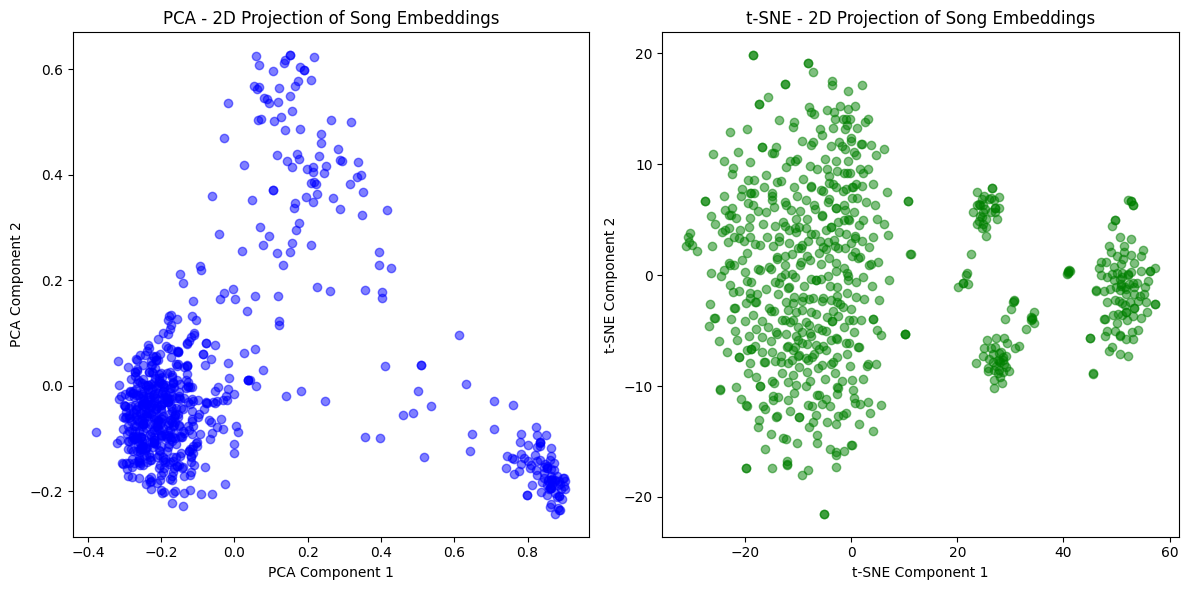

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Convert 'final_embedding' from list to a 2D NumPy array
embeddings = np.array(df['final_embedding'].tolist())

# Step 1: PCA (to reduce dimensionality to 2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Step 2: t-SNE (to reduce to 2D for visualization)
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Step 3: Plot PCA results
plt.figure(figsize=(12, 6))

# PCA Visualization
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, c='blue', marker='o')
plt.title('PCA - 2D Projection of Song Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Step 4: Plot t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5, c='green', marker='o')
plt.title('t-SNE - 2D Projection of Song Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Convert 'final_embedding' to a NumPy array if not done already
embeddings = np.array(df['final_embedding'].tolist())

# Step 2: Calculate the cosine similarity matrix for all songs
cos_sim_matrix = cosine_similarity(embeddings)

# Step 3: Find the most similar songs to a specific song (e.g., song with index 0)
song_index = 0
similarity_scores = cos_sim_matrix[song_index]

# Step 4: Sort the songs based on similarity scores (excluding the song itself)
similar_songs_indices = similarity_scores.argsort()[::-1][1:]  # Exclude the song itself
similar_songs_scores = similarity_scores[similar_songs_indices]

# Step 5: Display the most similar songs (e.g., top 5)
for i, idx in enumerate(similar_songs_indices[:5]):
    print(f"Rank {i+1}: Song ID {df.iloc[idx]['track_id']} | Similarity Score: {similar_songs_scores[i]}")


Rank 1: Song ID 3rTnGUeDrnZV22DvRuUuXr | Similarity Score: 1.0000001192092896
Rank 2: Song ID 5kYDyw9Vf23gHgsNMol2hb | Similarity Score: 0.5564102530479431
Rank 3: Song ID 2plbrEY59IikOBgBGLjaoe | Similarity Score: 0.5277266502380371
Rank 4: Song ID 5L79aNYCTKiZq7vaOElXYj | Similarity Score: 0.5252519845962524
Rank 5: Song ID 2KCqAdd2ad0hpJc5ySoTE8 | Similarity Score: 0.5213573575019836


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Convert 'final_embedding' to a NumPy array if not done already
embeddings = np.array(df['final_embedding'].tolist())

# Step 2: Calculate the cosine similarity matrix for all songs
cos_sim_matrix = cosine_similarity(embeddings)

# Step 3: Find the most similar songs to a specific song (e.g., song with index 0)
song_index = 0  # You can replace this with the index of any song you want to find similarities for
similarity_scores = cos_sim_matrix[song_index]

# Step 4: Sort the songs based on similarity scores (excluding the song itself)
similar_songs_indices = similarity_scores.argsort()[::-1][1:]  # Exclude the song itself
similar_songs_scores = similarity_scores[similar_songs_indices]

# Step 5: Display the most similar songs (e.g., top 5)
for i, idx in enumerate(similar_songs_indices[:5]):
    track_id = df.iloc[idx]['track_id']
    track_name = df.iloc[idx]['track_name']  # Get the song name from the DataFrame
    print(f"Rank {i+1}: Track ID: {track_id} | Song Name: {track_name} | Similarity Score: {similar_songs_scores[i]}")


Rank 1: Track ID: 3rTnGUeDrnZV22DvRuUuXr | Song Name: Wait | Similarity Score: 1.0000001192092896
Rank 2: Track ID: 5kYDyw9Vf23gHgsNMol2hb | Song Name: Waves | Similarity Score: 0.5564102530479431
Rank 3: Track ID: 2plbrEY59IikOBgBGLjaoe | Song Name: Die With A Smile | Similarity Score: 0.5277266502380371
Rank 4: Track ID: 5L79aNYCTKiZq7vaOElXYj | Song Name: Gone, Gone, Gone | Similarity Score: 0.5252519845962524
Rank 5: Track ID: 2KCqAdd2ad0hpJc5ySoTE8 | Song Name: Coastline | Similarity Score: 0.5213573575019836


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Convert 'final_embedding' to a NumPy array if not done already
embeddings = np.array(df['final_embedding'].tolist())

# Step 2: Specify the reference song (e.g., song with index 0)
song_index = 12  # Change this to the index of the song you're interested in
reference_song_name = df.iloc[song_index]['track_name']  # Get the reference song name

# Step 3: Calculate the cosine similarity matrix for all songs
cos_sim_matrix = cosine_similarity(embeddings)

# Step 4: Get the cosine similarity scores for the reference song
similarity_scores = cos_sim_matrix[song_index]

# Step 5: Sort the songs based on similarity scores (excluding the reference song itself)
similar_songs_indices = similarity_scores.argsort()[::-1][1:]  # Exclude the song itself
similar_songs_scores = similarity_scores[similar_songs_indices]

# Step 6: Display the reference song and the most similar songs
print(f"Reference Song: {reference_song_name}\n")

for i, idx in enumerate(similar_songs_indices[:5]):
    track_id = df.iloc[idx]['track_id']
    track_name = df.iloc[idx]['track_name']  # Get the song name from the DataFrame
    similarity_score = similar_songs_scores[i]
    print(f"Rank {i+1}: Track ID: {track_id} | Song Name: {track_name} | Similarity Score: {similarity_score}")


Reference Song: Kasoor

Rank 1: Track ID: 18YHbIhrleUkKKj2DvEp79 | Song Name: Zara Sa | Similarity Score: 0.9023032188415527
Rank 2: Track ID: 0pPGUL7171TRGgI6wyP8wP | Song Name: Tumhe Jo Maine Dekha | Similarity Score: 0.8989158272743225
Rank 3: Track ID: 2jMsqX0TfKTi24dZSSPjbo | Song Name: Kaise Bataaoon | Similarity Score: 0.8924756050109863
Rank 4: Track ID: 27FjnefSYiOgaG6jhytdE2 | Song Name: Kaise Bataaoon | Similarity Score: 0.8924756050109863
Rank 5: Track ID: 4LtSTc3xANVhYeeN69nscM | Song Name: Aaftaab | Similarity Score: 0.8887156248092651
